Hi all! This is a starter kernel of Deep Learning for Computer Vision.

 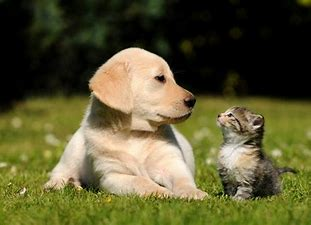

# **Importing Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

The data is preset in zip files, hence we need to extract the images from the zipfile.

In [ ]:
%%time
import zipfile
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip",'r') as z:
    z.extractall(".")
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip",'r') as z:
    z.extractall(".")

# **Label training data**

In [ ]:
filenames = os.listdir('/kaggle/working/train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(str(1))
    else:
        categories.append(str(0))

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()

We can see that there are two categories of dogs (1) and cats (0).

In [ ]:
df["category"].value_counts()

The categories are equally divided into two proportions i.e. there are 12500 pictures of each category.

# **Data Visualization**

In [ ]:
import random
from keras.preprocessing.image import load_img
sample = random.choice(filenames)
image = load_img("/kaggle/working/train/"+sample)
plt.imshow(image)

Oh wow! Such a cute dog!

# **Split into Train and Validation sets**

In [ ]:
x_train, x_val = train_test_split(df, test_size=0.2, random_state=2)

In [ ]:
x_train.head(), x_val.head()

We can see that the index are not ordered, let's try to change them.

In [ ]:
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)

In [ ]:
x_train.head(), x_val.head()

In [ ]:
print(x_train.shape)
print(x_val.shape)

# **Data Preprocessing**

As you already know by now, data should be formatted into appropriately pre-processed
floating point tensors before being fed into our network. Currently, our data sits on a
drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0,1] interval (as you know, neural
networks prefer to deal with small input values).

The saviour for this task is keras!!

# **Data Augmentation**

Overfitting is caused by having too few samples to learn from, rendering us unable to
train a model able to generalize to new data. Given infinite data, our model would be
exposed to every possible aspect of the data distribution at hand: we would never overfit.
Data augmentation takes the approach of generating more training data from existing
training samples, by "augmenting" the samples via a number of random transformations
that yield believable-looking images. The goal is that at training time, our model would
never see the exact same picture twice. This helps the model get exposed to more aspects
of the data and generalize better.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255)


valid_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255)

Let’s quickly go over what we just wrote:

1. rotation_range is a value in degrees (0-180), a range within which to randomly rotate
pictures.
2. width_shift and height_shift are ranges (as a fraction of total width or height)
within which to randomly translate pictures vertically or horizontally.
3. shear_range is for randomly applying shearing transformations.
4. zoom_range is for randomly zooming inside pictures.
5. horizontal_flip is for randomly flipping half of the images horizontally—relevant
when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).
6. fill_mode is the strategy used for filling in newly created pixels, which can appear after
a rotation or a width/height shift.

Let's see augmented image!

In [ ]:
from tensorflow.keras.preprocessing import image
fnames = [os.path.join('/kaggle/working/train', filename) for filename in os.listdir('/kaggle/working/train')]
img_path = fnames[3]

img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1):
 plt.figure(i)
 imgplot = plt.imshow(image.array_to_img(batch[0]))
 i += 1
 if i % 4 == 0:
        break
plt.show()

Looks like cat is waiting for someone! Hahaha!!

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    x_train,
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=15
 )

valid_generator = valid_datagen.flow_from_dataframe( 
    x_val,
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=15
 )

Let's see the shape.

In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Here the shape of data batch is (15, 128, 128, 3), where 15 is the number of samples in each batch, 128 * 128 refers to the height and width of the image and 3 refers to the RGB.

In [ ]:
for data_batch, labels_batch in valid_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

# **CNN Model**

In [ ]:
model = keras.models.Sequential([
                         keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1,1), padding='valid',activation= 'relu', input_shape=(128,128,3)),
                         keras.layers.MaxPooling2D(pool_size=(2,2)),
                         keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same', activation='relu'),
                         keras.layers.MaxPooling2D(pool_size=(2,2)),
                         keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu'),
                         keras.layers.MaxPooling2D(pool_size=(2,2)),
                         keras.layers.Flatten(),
                         keras.layers.Dense(units=128, activation='relu'),
                         keras.layers.Dropout(0.25),
                         keras.layers.Dense(units=256, activation='relu'),
                         keras.layers.Dropout(0.5),
                         keras.layers.Dense(units=256, activation='relu'),
                         keras.layers.Dropout(0.25),                        
                         keras.layers.Dense(units=128, activation='relu'),
                         keras.layers.Dropout(0.10),                         
                         keras.layers.Dense(units=2, activation='softmax')
])


In [ ]:
model.summary()

# **Compile Model**

In [ ]:
model.compile(loss='categorical_crossentropy',
 optimizer="adam",
 metrics=['accuracy'])

# **Fit Model**

In [ ]:
history = model.fit(train_generator, epochs=30, verbose=1, validation_data=valid_generator)

# **Save Model**

In [ ]:
model.save('cats_and_dogs_2.h5')

# **Plots Between Accuracy and Loss**

In [ ]:
history.history.keys()

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# **Conclusion**

We can see that with the number of epochs the training as well as validation accuracy increases and hence after using data augmentation we have prevented overfitting. And the loss also increases as the number of epochs increases.

If you find my work helpful, please upvote! Open for criticism!!

Thanks You!